<a href="https://colab.research.google.com/github/dimimath/FinalProject/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
file_path = '/content/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(file_path)


print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())


print("\nMissing values per column:")
print(df.isnull().sum())


print("\nDataset Info:")
print(df.info())

print("\nDataset Description:")
print(df.describe(include='all'))


print("\nImputing missing values for 'bmi' column with median:")



Dataset Shape: (5110, 12)

First 5 rows:
       id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

Missing value

In [3]:
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

print("Missing values after imputation:")
print(df.isnull().sum())

from sklearn.preprocessing import LabelEncoder

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print("\nEncoded Categorical Columns:")
print(df[categorical_cols].head())

Missing values after imputation:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Encoded Categorical Columns:
   gender  ever_married  work_type  Residence_type  smoking_status
0       1             1          2               1               1
1       0             1          3               0               2
2       1             1          2               0               2
3       0             1          2               1               3
4       0             1          3               0               2


In [4]:
from sklearn.impute import KNNImputer


num_cols = ['age', 'avg_glucose_level', 'bmi']
imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])


In [5]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(df[num_cols])


df = df[outliers == 1].reset_index(drop=True)


In [6]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [7]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.5 MB/s eta 0:00:00


In [8]:
from category_encoders import TargetEncoder

cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
target_enc = TargetEncoder(cols=cat_cols)
df[cat_cols] = target_enc.fit_transform(df[cat_cols], df['stroke'])


In [9]:
# 1. Age group
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 60, 100], labels=[0, 1, 2])
df['age_group'] = df['age_group'].cat.add_categories([3]).fillna(3)  # αν θέλεις 'other' group

df['age_group'] = df['age_group'].astype(int)

# 2. BMI * Glucose (risk factor combo)
df['bmi_glucose'] = df['bmi'] * df['avg_glucose_level']

# 3. Hypertension & Heart Disease combo
df['ht_hd_combo'] = df['hypertension'] * df['heart_disease']


In [10]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

X = df.drop(['stroke', 'id'], axis=1)
y = df['stroke']


print("\nMissing values in X before feature selection:")
print(X.isnull().sum())




Missing values in X before feature selection:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
age_group            0
bmi_glucose          0
ht_hd_combo          0
dtype: int64


In [11]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['stroke', 'id'], axis=1)
y = df['stroke']

# SelectKBest
kbest = SelectKBest(score_func=f_classif, k=8)
X_kbest = kbest.fit_transform(X, y)
print("SelectKBest features:", X.columns[kbest.get_support()])

# Tree-based importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top Tree-based features:\n", importances.head(8))


SelectKBest features: Index(['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'avg_glucose_level', 'smoking_status', 'age_group'],
      dtype='object')
Top Tree-based features:
 avg_glucose_level    0.218092
bmi_glucose          0.187987
age                  0.187724
bmi                  0.172607
smoking_status       0.058952
work_type            0.038758
Residence_type       0.027475
gender               0.025201
dtype: float64


In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print(f"PCA reduced features: {X_pca.shape[1]}")


PCA reduced features: 4


In [13]:
from sklearn.model_selection import train_test_split, StratifiedKFold

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)



In [14]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_res).value_counts())


Before SMOTE: stroke
0    2888
1     146
Name: count, dtype: int64
After SMOTE: stroke
0    2888
1    2888
Name: count, dtype: int64


In [15]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 21.0 MB/s eta 0:00:00


In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import optuna
import xgboost as xgb

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'use_label_encoder': False,
        'eval_metric': 'auc'
    }

    model = XGBClassifier(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    preds = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, preds)
    return auc






In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best parameters:", study.best_params)
print("Best AUC:", study.best_value)


[I 2025-06-25 12:59:59,942] A new study created in memory with name: no-name-2c65f22a-150e-4e6b-92d7-3adaa4456f3f
[I 2025-06-25 13:00:00,684] Trial 0 finished with value: 0.78294869349609 and parameters: {'max_depth': 4, 'n_estimators': 273, 'learning_rate': 0.18534841901210394, 'subsample': 0.8836779151643839, 'colsample_bytree': 0.6807753856468663, 'scale_pos_weight': 2.7016287184736307}. Best is trial 0 with value: 0.78294869349609.
[I 2025-06-25 13:00:01,271] Trial 1 finished with value: 0.81348676542268 and parameters: {'max_depth': 6, 'n_estimators': 250, 'learning_rate': 0.05346060980657422, 'subsample': 0.726842077743947, 'colsample_bytree': 0.7114924520013692, 'scale_pos_weight': 8.415325929485558}. Best is trial 1 with value: 0.81348676542268.
[I 2025-06-25 13:00:02,957] Trial 2 finished with value: 0.8060906605632908 and parameters: {'max_depth': 10, 'n_estimators': 211, 'learning_rate': 0.2458186853660802, 'subsample': 0.6104648868562712, 'colsample_bytree': 0.8875795427249

Best parameters: {'max_depth': 3, 'n_estimators': 193, 'learning_rate': 0.028247133587895285, 'subsample': 0.9866929361637456, 'colsample_bytree': 0.9888127786827626, 'scale_pos_weight': 3.9444705449377055}
Best AUC: 0.8632462330726682


In [18]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_res.value_counts())

After SMOTE: stroke
0    2888
1    2888
Name: count, dtype: int64


In [19]:
best_params = study.best_params
best_model = XGBClassifier(**best_params)
best_model.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9888127786827626, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.028247133587895285,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=193, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
# Predict probabilities on the original validation set
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# ROC Curve & Optimal Threshold
optimal_threshold = 0.5
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
for thr, rec in zip(thresholds, tpr):
    if rec >= 0.90:
        optimal_threshold = thr
        break
#optimal_idx = np.argmax(tpr - fpr)
#οptimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

# Apply optimal threshold
y_pred = (y_pred_proba > optimal_threshold).astype(int)

# Evaluation
print("\nClassification Report:\n", classification_report(y_valid, y_pred, zero_division=0))
print("ROC AUC Score:", roc_auc_score(y_valid, y_pred_proba))


Optimal Threshold: 0.17324

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.55      0.71       963
           1       0.09      0.90      0.17        49

    accuracy                           0.57      1012
   macro avg       0.54      0.72      0.44      1012
weighted avg       0.95      0.57      0.68      1012

ROC AUC Score: 0.8258418632250408


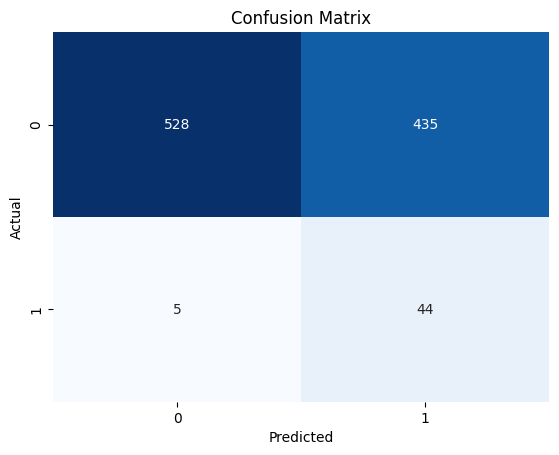

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



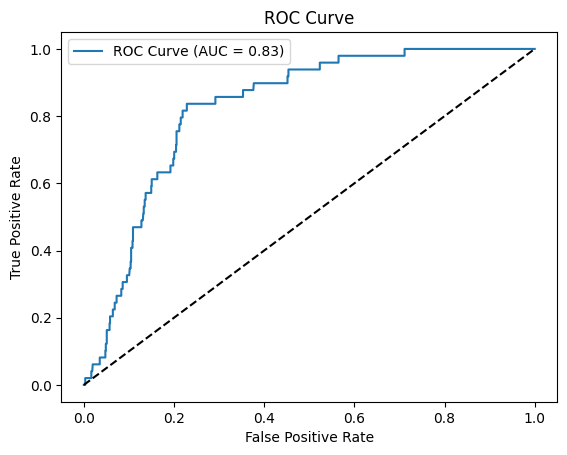

In [22]:
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_valid, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


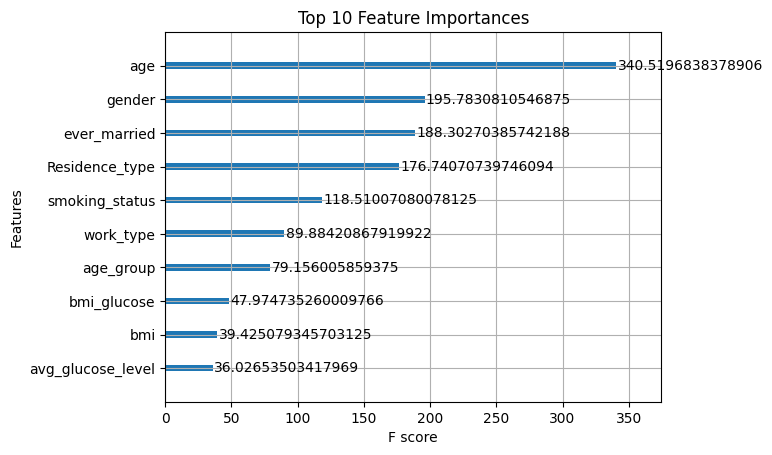

In [23]:
xgb.plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title('Top 10 Feature Importances')
plt.show()


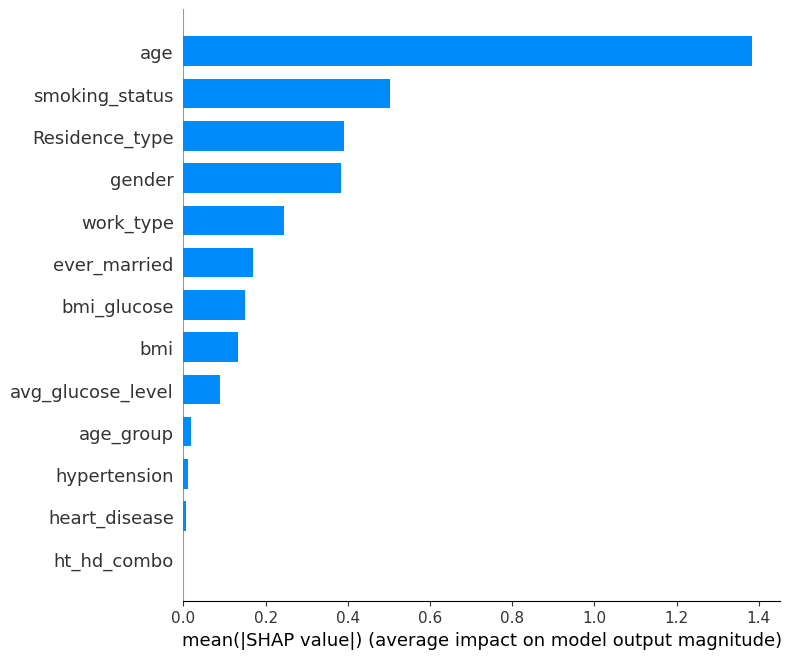

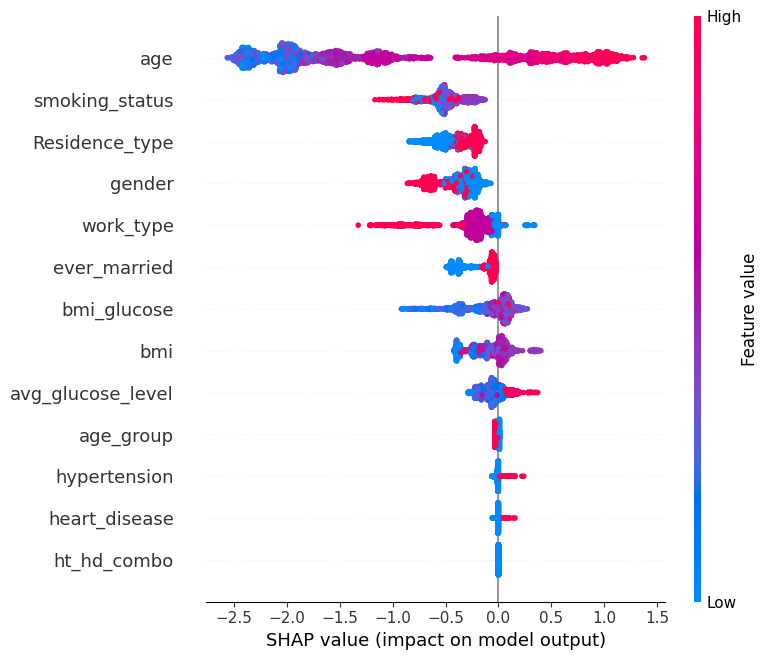

In [24]:
import shap
import pandas as pd  # Ensure pandas is imported if not already

explainer = shap.Explainer(best_model)
# Use the X_train DataFrame directly with the explainer
shap_values = explainer(X_train)

# Summary Plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Detailed summary plot
shap.summary_plot(shap_values, X_train)


In [25]:
!pip install scikit-learn

In [30]:
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler

with open("model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [31]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, conint, confloat
import pickle
import numpy as np
import pandas as pd

# Load the trained model (with preprocessing pipeline inside)
with open("model.pkl", "rb") as f:
    model = pickle.load(f)

app = FastAPI(title="Stroke Prediction API")

class StrokeInput(BaseModel):
    gender: str
    age: conint(ge=0, le=120)
    hypertension: conint(ge=0, le=1)
    heart_disease: conint(ge=0, le=1)
    ever_married: str
    work_type: str
    Residence_type: str
    avg_glucose_level: confloat(ge=0)
    bmi: confloat(ge=0)
    smoking_status: str

# Output schema
class StrokeOutput(BaseModel):
    stroke_probability: float
    prediction: int

@app.post("/predict", response_model=StrokeOutput)
def predict(input_data: StrokeInput):
    try:
        # Convert to DataFrame (as during training)
        input_df = pd.DataFrame([input_data.dict()])

        # Apply model (assumes full pipeline: preprocessing + model)
        prediction_proba = model.predict_proba(input_df)[0, 1]
        prediction = model.predict(input_df)[0]

        return StrokeOutput(
            stroke_probability=round(float(prediction_proba), 4),
            prediction=int(prediction)
        )
    except Exception as e:
        raise HTTPException(status_code=400, detail=f"Prediction error: {str(e)}")

In [32]:
import pickle
pickle.dump(best_model, open("model.pkl", "wb"))


In [33]:
{
  "gender": "Male",
  "age": 67,
  "hypertension": 0,
  "heart_disease": 1,
  "ever_married": "Yes",
  "work_type": "Private",
  "Residence_type": "Urban",
  "avg_glucose_level": 85.5,
  "bmi": 26.3,
  "smoking_status": "never smoked"
}


{'gender': 'Male',
 'age': 67,
 'hypertension': 0,
 'heart_disease': 1,
 'ever_married': 'Yes',
 'work_type': 'Private',
 'Residence_type': 'Urban',
 'avg_glucose_level': 85.5,
 'bmi': 26.3,
 'smoking_status': 'never smoked'}